<a href="https://colab.research.google.com/github/saquibali7/GANs/blob/main/GAN3_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randint

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


In [3]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    super(Discriminator, self).__init__()

    self.disc = nn.Sequential(
        nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        self._block(features_d, features_d*2, 4,2,1),
        self._block(features_d*2, features_d*4, 4,2,1),
        self._block(features_d*4, features_d*8, 4,2,1),
        nn.Conv2d(features_d*8,1,kernel_size=4,stride=2,padding = 0),
    )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
      return nn.Sequential(
          nn.Conv2d(in_channels,out_channels, kernel_size, stride, padding, bias=False),
          nn.InstanceNorm2d(out_channels, affine=True),
          nn.LeakyReLU(0.2),
      )

  def forward(self, x):
        return self.disc(x)

In [4]:
class Generator(nn.Module):
  def __init__(self, channels_noise, channels_img, features_g):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        self._block(channels_noise, features_g*16, 4, 1, 0),
        self._block(features_g*16, features_g*8, 4,2,1),
        self._block(features_g*8, features_g*4, 4,2,1),
        self._block(features_g*4, features_g*2, 4,2,1),
        nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
    )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
      return nn.Sequential(
          nn.ConvTranspose2d(
                    in_channels, 
                    out_channels, 
                    kernel_size, 
                    stride, 
                    padding, 
                    bias=False),
          nn.BatchNorm2d(out_channels), ## for WGAN with gradient penalty use nn.InstanceNorm2d
          nn.ReLU(),          
                  
      )

  def forward(self, x):
        return self.gen(x)

In [5]:
def initialise_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal(m.weight.data, 0.0, 0.02)

In [6]:
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  noise_dim = 100
  x = torch.randn(N, in_channels, H, W)
  disc = Discriminator(in_channels, 8)
  initialise_weights(disc)
  assert disc(x).shape == (N,1,1,1), "fail"
  gen = Generator(noise_dim, in_channels, 8)
  initialise_weights(gen)
  z = torch.randn(N, noise_dim, 1, 1)
  assert gen(z).shape == (N, in_channels, H, W), "fail"

In [7]:
test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE= 5e-5 ## form WGAN with gradient penalty lr = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 128
EPOCHS = 150
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHTS_CLIP = 0.01

In [9]:
transforms = transforms.Compose(
    [
     transforms.Resize(IMAGE_SIZE),
     transforms.ToTensor(),
     transforms.Normalize(
         [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
     ),
    ]
)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
path = '/content/drive/MyDrive/Morula/'
file = os.listdir(path)
print(len(file))

1478


In [12]:
from PIL import Image

(500, 500, 3)


(-0.5, 499.5, 499.5, -0.5)

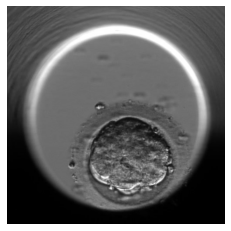

In [13]:
ix = randint(0, len(file))
rand_img = Image.open(os.path.join(path,file[ix]))
rand_img = np.array(rand_img)
print(rand_img.shape)
plt.imshow(rand_img)
plt.axis("off")

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [15]:
train_transforms = A.Compose(
    [   
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(
         [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
        ToTensorV2(),
    ]
)

In [16]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
from PIL import Image

In [17]:
class ImageDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.files = os.listdir(root_dir)
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    img_file = self.files[idx]
    img_path = os.path.join(self.root_dir, img_file)
    img = np.array(Image.open(img_path))
    if self.transform:
      img = self.transform(image=img)['image']
    return img

In [18]:
dataset = ImageDataset(root_dir=path, transform=train_transforms)
loader = DataLoader(dataset, batch_size = BATCH_SIZE)

gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

In [19]:
initialise_weights(critic)
initialise_weights(gen)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)
opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.


torch.Size([3, 64, 64])
tensor(1.)


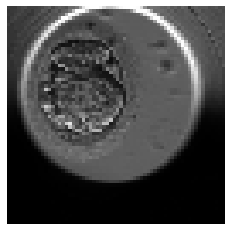

In [20]:
for batch , image in enumerate(loader):
  print(image[3].shape)
  print( torch.max(image[0]))
  img = image[0]*0.5+0.5
  plt.imshow(img.permute(1, 2, 0))
  plt.axis("off")
  break

In [21]:
!pip install wandb
import wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 181 kB 56.6 MB/s 
     |████████████████████████████████| 157 kB 63.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 157 kB 65.5 MB/s 
     |████████████████████████████████| 157 kB 65.5 MB/s 
     |████████████████████████████████| 156 kB 41.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=3225b87217c170dcf8cf0f259a9f38304f56429c4f5503e29f03d3afc8a08dc7
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [22]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty



In [24]:
from torchvision.utils import make_grid

In [25]:
step=0
critic.train()
gen.train()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, 

In [26]:
wandb.init("task-01")

for epoch in range(EPOCHS):
  for batch_idx, (real) in enumerate(loader):
    real = real.to(device)
    curr_batch_size = real.shape[0]

    for _ in range(CRITIC_ITERATIONS):
      noise = torch.randn(curr_batch_size, NOISE_DIM, 1, 1).to(device)
      fake = gen(noise)
      critic_real = critic(real).reshape(-1)
      critic_fake = critic(fake).reshape(-1)
      gp = gradient_penalty(critic, real, fake, device=device)
      critic_loss = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + 10 * gp)
      critic.zero_grad()
      critic_loss.backward(retain_graph=True)
      opt_critic.step()  

    ## Training of Generator
    
    gen_fake = critic(fake).reshape(-1)
    loss_gen = -torch.mean(gen_fake)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    
  wandb.log({"Generartor  Loss": loss_gen, 'epoch':epoch })
  wandb.log({"Discriminator Loss": critic_loss, 'epoch':epoch })

  with torch.inference_mode():
   for batch_idx, real_img in enumerate(loader):
     noise = torch.randn(curr_batch_size, NOISE_DIM, 1, 1).to(device)
     fake_img = gen(noise)
     grid1 = make_grid(real_img)
     grid2 = make_grid(fake_img)
     grid1 = wandb.Image(grid1, caption="Original Image")
     grid2 = wandb.Image(grid2, caption="Fake Image")
     wandb.log({"Original Image ": grid1})
     wandb.log({"Fake Image": grid2})

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [27]:
%cd '/content/drive/MyDrive/model'

/content/drive/MyDrive/model


In [32]:
torch.save(gen.state_dict(), './genT01.pth')

In [33]:
torch.save(critic.state_dict(), './disc01.pth')

(-0.5, 63.5, 63.5, -0.5)

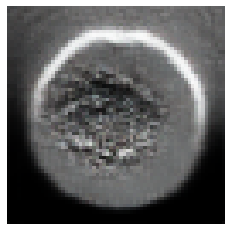

In [31]:
x = torch.randn(1,NOISE_DIM, 1, 1).to(device)
out = gen(x)
out = out.cpu().detach()
img = out[0]*0.5+0.5
plt.imshow(img.permute(1,2,0))
plt.axis("off")

In [36]:
model = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/model/genT01.pth'))
model.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, 

(-0.5, 63.5, 63.5, -0.5)

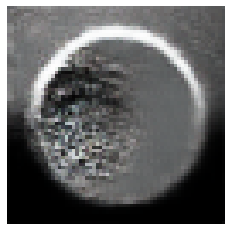

In [37]:
x = torch.randn(1,NOISE_DIM, 1, 1).to(device)
out = model(x)
out = out.cpu().detach()
img = out[0]*0.5+0.5
plt.imshow(img.permute(1,2,0))
plt.axis("off")